# COVID-19 Detection Using Multi-Phase Training of ConvNets with Multi-Class Imbalanced Chest CT Scan Data

The main sections of the notebook are:

1. [Import Needed Libraries](#a)
2. [Logistic Regression](#b)
3. [Training with smotesampled Data](#c)
4. [Two-Phase Training with Undersampling](#d)
5. [Multi-Phase Training with Undersampling](#e)

<div style="text-align: right"> Ahmet Talha Yiğit / 507191101 </div>

<a id=’a’></a>
### 1. Import Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from sklearn.metrics import average_precision_score,PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit,GridSearchCV
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from imblearn.combine import SMOTEENN

# Import needed packages for the model building and stage
#from skimage import io, transform
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils       
from torchvision.utils import make_grid
import torch.optim as optim
from skorch import NeuralNetClassifier
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
import random
random.seed(102022)
np.random.seed(102022)

c:\Users\ahmet\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def lift_scorer(target, pred_proba):
    
    df = pd.DataFrame(pred_proba)
    df.columns = ['pred_proba']
    df['target'] = target.values
    df['pred_proba_rank'] = df['pred_proba'].rank(ascending = False).astype(int)
    lift = round(df[df['pred_proba_rank'] <= round(df['pred_proba_rank'].max() * (1/100), 0)]['target'].sum() / df['target'].sum() * 100, 1)

    return lift

In [3]:
X_train = pd.read_pickle('./Data/X_train_preprocessed.pkl')
y_train = pd.read_pickle('./Data/y_train_preprocessed.pkl')
X_val = pd.read_pickle('./Data/X_val_preprocessed.pkl')
y_val = pd.read_pickle('./Data/y_val_preprocessed.pkl')
X_test = pd.read_pickle('./Data/X_test_preprocessed.pkl')
y_test = pd.read_pickle('./Data/y_test_preprocessed.pkl')

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000,), (7500, 33), (7500,), (7500, 33), (7500,))

In [5]:
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_val = X_val.reset_index()
y_val = y_val.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()

X_train['idx'] = 'Train'
y_train['idx'] = 'Train'
X_val['idx'] = 'Val'
y_val['idx'] = 'Val'
X_test['idx'] = 'Test'
y_test['idx'] = 'Test'

X_train['index'] = X_train['index'].astype('str')
y_train['index'] = y_train['index'].astype('str')
X_val['index'] = X_val['index'].astype('str')
y_val['index'] = y_val['index'].astype('str')
X_test['index'] = X_test['index'].astype('str')
y_test['index'] = y_test['index'].astype('str')

X_train['index'] = X_train[["index", "idx"]].apply("-".join, axis=1)
y_train['index'] = y_train[["index", "idx"]].apply("-".join, axis=1)
X_val['index'] = X_val[["index", "idx"]].apply("-".join, axis=1)
y_val['index'] = y_val[["index", "idx"]].apply("-".join, axis=1)
X_test['index'] = X_test[["index", "idx"]].apply("-".join, axis=1)
y_test['index'] = y_test[["index", "idx"]].apply("-".join, axis=1)

X_train = X_train.set_index('index')
y_train = y_train.set_index('index')
X_val = X_val.set_index('index')
y_val = y_val.set_index('index')
X_test = X_test.set_index('index')
y_test = y_test.set_index('index')

X_train = X_train.drop('idx', axis = 1)
y_train = y_train.drop('idx', axis = 1)
X_val = X_val.drop('idx', axis = 1)
y_val = y_val.drop('idx', axis = 1)
X_test = X_test.drop('idx', axis = 1)
y_test = y_test.drop('idx', axis = 1)

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000, 1), (7500, 33), (7500, 1), (7500, 33), (7500, 1))

In [7]:
X_train.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,...,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,
60075-Train,-0.109742,1.134404,-1.009085,-3.644704,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,-0.396241,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
27225-Train,-0.109742,0.075986,0.977945,-0.731477,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,0.533820,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
403-Train,-0.109742,0.075986,0.702450,-0.631123,0.562187,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,4.014773,0.240094,2.491077,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
27953-Train,-0.109742,-0.408430,0.702450,1.045385,0.613346,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,-0.249080,0.240094,0.169018,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
74481-Train,-0.109742,-0.408430,0.702450,0.077261,1.008509,1.183906,0.480831,0.641715,0.194911,-1.576622,...,-0.144079,0.475470,-0.249080,0.240094,0.455636,0.640053,-0.039831,-0.345385,-0.233373,-0.006544


<a id=’b’></a>
## 2. Logistic Regression

In [8]:
param_grid={"C":np.logspace(-2,2,5), 
            "class_weight": ['balanced', None]}
df = pd.DataFrame()
df['ratio'] = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

for y in [0,1,2,3]:
    if y == 0:
        print('Undersampling Gridsearch:')
    elif y == 1:
        print('Oversampling Gridsearch:')
    elif y == 2:
        print('SMOTE Gridsearch:')
    else:
        print('SMOTEENN Gridsearch:')
    for x in range(0,(df.shape[0])):

        if x == 0:
            X_gridsearch = X_train.append(X_val)
            y_gridsearch = y_train.append(y_val)
            split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = LogisticRegression(random_state = 102022, max_iter = 250)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1')
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_train,y_train.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            y_train_predict_proba = classifier_base.predict_proba(X_train)
            y_val_predict_proba = classifier_base.predict_proba(X_val)
            y_test_predict_proba = classifier_base.predict_proba(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            print("Resample ratio :", df.loc[x].values[0], " \t| tuned hpyerparameters:", gridsearch.best_params_, " \t| f1-score :", round(gridsearch.best_score_,4) )
        else:
            if y == 0:
                resample = RandomUnderSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 1:
                resample = RandomOverSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 2:
                resample = SMOTE(sampling_strategy = df.loc[x].values[0], random_state=102022)
            else:
                resample = SMOTEENN(sampling_strategy = df.loc[x].values[0], random_state=102022)
            X_resampled, y_resampled = resample.fit_resample(X_train, y_train)
            X_gridsearch = X_resampled.append(X_val)
            y_gridsearch = y_resampled.append(y_val)
            # Create a list where train data indices are -1 and validation data indices are 0
            split_index = [-1 if x in X_resampled.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = LogisticRegression(random_state = 102022, max_iter = 250)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1')

            # Fit with all data
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_resampled,y_resampled.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            y_train_predict_proba = classifier_base.predict_proba(X_train)
            y_val_predict_proba = classifier_base.predict_proba(X_val)
            y_test_predict_proba = classifier_base.predict_proba(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            
            print("Resample ratio:", df.loc[x].values[0], " \t| tuned hpyerparameters:", gridsearch.best_params_, " \t| f1-score_val:", round(gridsearch.best_score_,4) )


Undersampling Gridsearch:
Resample ratio : 0.01  	| tuned hpyerparameters: {'C': 0.01, 'class_weight': 'balanced'}  	| f1-score : 0.0591
Resample ratio: 0.03  	| tuned hpyerparameters: {'C': 0.1, 'class_weight': None}  	| f1-score_val: 0.1163
Resample ratio: 0.05  	| tuned hpyerparameters: {'C': 0.1, 'class_weight': None}  	| f1-score_val: 0.0971
Resample ratio: 0.07  	| tuned hpyerparameters: {'C': 0.1, 'class_weight': None}  	| f1-score_val: 0.125
Resample ratio: 0.1  	| tuned hpyerparameters: {'C': 1.0, 'class_weight': None}  	| f1-score_val: 0.1294
Resample ratio: 0.15  	| tuned hpyerparameters: {'C': 1.0, 'class_weight': None}  	| f1-score_val: 0.1417
Resample ratio: 0.2  	| tuned hpyerparameters: {'C': 0.01, 'class_weight': None}  	| f1-score_val: 0.1345
Resample ratio: 0.25  	| tuned hpyerparameters: {'C': 0.1, 'class_weight': None}  	| f1-score_val: 0.1357
Resample ratio: 0.3  	| tuned hpyerparameters: {'C': 0.01, 'class_weight': None}  	| f1-score_val: 0.1393
Resample ratio: 0

In [ ]:
df.head()

,ratio,precision_under_train,recall_under_train,f1score_under_train,rocauc_under_train,prauc_under_train,precision_under_val,recall_under_val,f1score_under_val,rocauc_under_val,...,precision_smote_val,recall_smote_val,f1score_smote_val,rocauc_smote_val,prauc_smote_val,precision_smote_test,recall_smote_test,f1score_smote_test,rocauc_smote_test,prauc_smote_test
0,0.01,0.032009,0.745000,0.061380,0.843617,0.095846,0.031927,0.746667,0.061236,0.830624,...,0.031927,0.746667,0.061236,0.830624,0.091354,0.032311,0.786667,0.062073,0.847125,0.081983
1,0.03,0.321739,0.061667,0.103497,0.841282,0.108281,0.428571,0.040000,0.073171,0.817636,...,0.444444,0.053333,0.095238,0.811424,0.092452,0.214286,0.040000,0.067416,0.839354,0.088192
2,0.05,0.243781,0.081667,0.122347,0.841490,0.106466,0.357143,0.066667,0.112360,0.822043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.07,0.236434,0.101667,0.142191,0.841498,0.107528,0.185185,0.066667,0.098039,0.822247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.10,0.224852,0.126667,0.162047,0.841379,0.103927,0.194444,0.093333,0.126126,0.821901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df[['ratio','prauc_smoteenn_train', 'prauc_smoteenn_val', 'prauc_smoteenn_test']].head()

,ratio,prauc_smoteenn_train,prauc_smoteenn_val,prauc_smoteenn_test
0,0.01,0.100070,0.089387,0.083313
1,0.03,0.106616,0.083050,0.091882
2,0.05,0.109804,0.092193,0.096411
3,0.07,0.106915,0.092806,0.090578
4,0.10,0.105598,0.093768,0.091193


In [10]:
df.loc[4,['ratio','f1score_smoteenn_train', 'f1score_smoteenn_val', 'f1score_smoteenn_test']].head()

ratio                     0.100000
f1score_smoteenn_train    0.179086
f1score_smoteenn_val      0.150000
f1score_smoteenn_test     0.172589
Name: 4, dtype: float64

In [11]:
df.to_pickle('LR_Gridsearch_df.pkl')

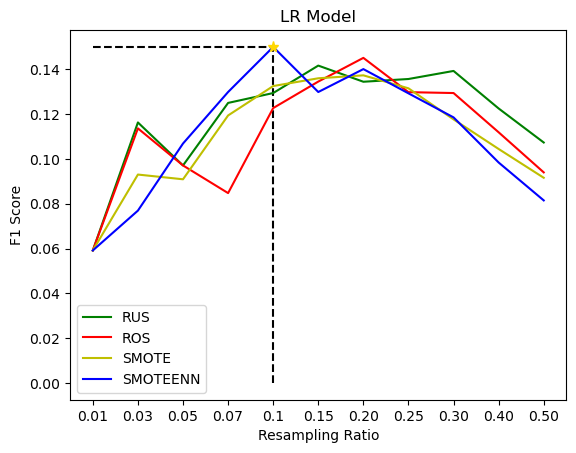

In [12]:
df_LR = df

# Define data values
x = ['0.01', '0.03', '0.05', '0.07', '0.1', '0.15', '0.20', '0.25', '0.30', '0.40', '0.50']
y = df_LR['f1score_under_val'].values
z = df_LR['f1score_over_val'].values
a = df_LR['f1score_smote_val'].values
b = df_LR['f1score_smoteenn_val'].values

# Plot a simple line chart
plt.plot(x, y, 'g', label='RUS')
plt.plot(x, z, 'r', label='ROS')
plt.plot(x, a, 'y', label='SMOTE')
plt.plot(x, b, 'b', label='SMOTEENN')

plt.plot('0.1', max(df_LR['f1score_smoteenn_val'].values), marker = '*', ms = 8, mec = 'gold', mfc = 'gold')
plt.hlines(max(df_LR['f1score_smoteenn_val'].values), 0, '0.1', color='black', linestyles= 'dashed')  # Stems
plt.vlines('0.1', 0, max(df_LR['f1score_smoteenn_val'].values), color='black', linestyles= 'dashed')  # Stems
plt.xlabel("Resampling Ratio")
plt.ylabel("F1 Score")
plt.title("LR Model")
plt.legend()
plt.show()

In [18]:
classifier_base = LogisticRegression(random_state = 102022, max_iter = 250)
classifier_tuned = LogisticRegression(random_state = 102022, max_iter = 250, C = 0.01, class_weight = 'balanced')
classifier_resampled_tuned = LogisticRegression(random_state = 102022, max_iter = 250, C = 0.01, class_weight = None)

resample = SMOTEENN(sampling_strategy = 0.1, random_state=102022)
X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

classifier_base.fit(X_train, y_train.values.ravel())
classifier_tuned.fit(X_train, y_train.values.ravel())
classifier_resampled_tuned.fit(X_resampled, y_resampled.values.ravel())

LogisticRegression(C=0.01, max_iter=250, random_state=102022)

In [19]:
y_train_predict_base = classifier_base.predict(X_train)
y_val_predict_base = classifier_base.predict(X_val)
y_test_predict_base = classifier_base.predict(X_test)
y_train_predict_proba_base = classifier_base.predict_proba(X_train)
y_val_predict_proba_base = classifier_base.predict_proba(X_val)
y_test_predict_proba_base = classifier_base.predict_proba(X_test)

y_train_predict_tuned = classifier_tuned.predict(X_train)
y_val_predict_tuned = classifier_tuned.predict(X_val)
y_test_predict_tuned = classifier_tuned.predict(X_test)
y_train_predict_proba_tuned = classifier_tuned.predict_proba(X_train)
y_val_predict_proba_tuned = classifier_tuned.predict_proba(X_val)
y_test_predict_proba_tuned = classifier_tuned.predict_proba(X_test)

y_train_predict_resampled_tuned = classifier_resampled_tuned.predict(X_train)
y_val_predict_resampled_tuned = classifier_resampled_tuned.predict(X_val)
y_test_predict_resampled_tuned = classifier_resampled_tuned.predict(X_test)
y_train_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_train)
y_val_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_val)
y_test_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_test)

In [20]:
accuracy = accuracy_score(y_val,y_val_predict_base)
precision = precision_score(y_val,y_val_predict_base)
recall = recall_score(y_val,y_val_predict_base)
f1 = f1_score(y_val,y_val_predict_base)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_base[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_base[:,1])
print('Base Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_tuned)
precision = precision_score(y_val,y_val_predict_tuned)
recall = recall_score(y_val,y_val_predict_tuned)
f1 = f1_score(y_val,y_val_predict_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_tuned[:,1])
print('Tuned Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Base Model: 	accuracy: 0.9899 	precision: 0.3333 	recall: 0.0133 	f1: 0.0256 	roc_auc: 0.8051 	lift: 9.3
Tuned Model: 	accuracy: 0.7709 	precision: 0.0308 	recall: 0.72 	f1: 0.0591 	roc_auc: 0.8135 	lift: 13.3
R&T Model: 	accuracy: 0.9773 	precision: 0.12 	recall: 0.2 	f1: 0.15 	roc_auc: 0.8108 	lift: 13.3


In [16]:
print('----------------------------------------------------------------------------------')
cm_base = confusion_matrix(y_val,y_val_predict_base) #Create a confusion matrix of GT labels and predictions
print('CM Base')
print(cm_base)
cm_tuned = confusion_matrix(y_val,y_val_predict_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Tuned')
print(cm_tuned)
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Base
[[7423    2]
 [  74    1]]
----------------------------------------------------------------------------------
CM Tuned
[[5728 1697]
 [  21   54]]
----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7315  110]
 [  60   15]]
----------------------------------------------------------------------------------


Plot PR curves of Resampled & Tuned Model:


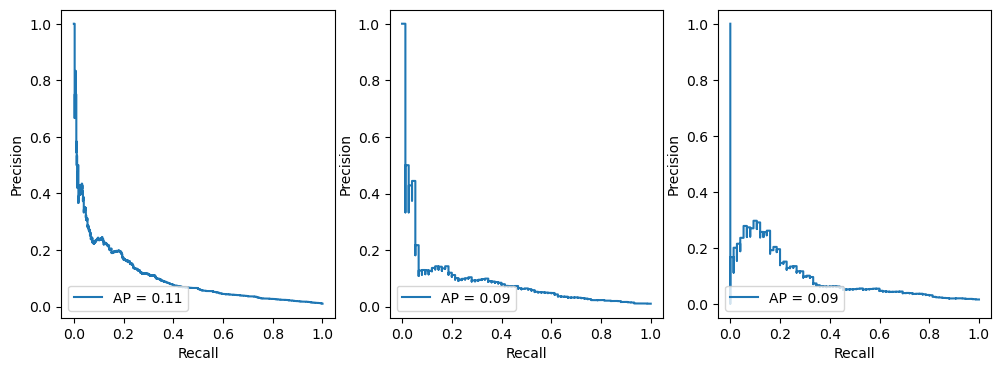

PR_AUC Train: 0.1056 	| PR_AUC Val: 0.0938 	| PR_AUC Test: 0.0912


In [17]:
print('Plot PR curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba_resampled_tuned[:,1])
AP_train = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
PR_curve_train.plot(ax1)
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba_resampled_tuned[:,1])
AP_val = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
PR_curve_val.plot(ax2)
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba_resampled_tuned[:,1])
AP_test = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
PR_curve_test.plot(ax3)
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))

In [18]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned[:,1])
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned[:,1])
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.9782 	precision: 0.1434 	recall: 0.2383 	f1: 0.1791 	roc_auc: 0.8405 	pr_auc: 0.1056 	lift_score: 19.2
R&T Model Val: 		accuracy: 0.9773 	precision: 0.12 	recall: 0.2 	f1: 0.15 	roc_auc: 0.8108 	pr_auc: 0.0938 	lift_score: 13.3
R&T Model Test: 	accuracy: 0.9783 	precision: 0.1393 	recall: 0.2267 	f1: 0.1726 	roc_auc: 0.8466 	pr_auc: 0.0912 	lift_score: 18.7


<a id=’b’></a>
## 3. Decision Tree

In [24]:
param_grid = {'criterion': ['gini','entropy'], 
              'max_depth':[2, 3, 4, 5], 
              'max_features':  [None,'auto'],
              'class_weight': [None, 'balanced']}
df = pd.DataFrame()
df['ratio'] = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

for y in [0,1,2,3]:
    if y == 0:
        print('Undersampling Gridsearch:')
    elif y == 1:
        print('Oversampling Gridsearch:')
    elif y == 2:
        print('SMOTE Gridsearch:')
    else:
        print('SMOTEENN Gridsearch:')
    for x in range(0,(df.shape[0])):

        if x == 0:
            X_gridsearch = X_train.append(X_val)
            y_gridsearch = y_train.append(y_val)
            split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = DecisionTreeClassifier(random_state = 102022)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1')
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_train,y_train.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            y_train_predict_proba = classifier_base.predict_proba(X_train)
            y_val_predict_proba = classifier_base.predict_proba(X_val)
            y_test_predict_proba = classifier_base.predict_proba(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            print("Resample ratio :", df.loc[x].values[0], " \t| tuned hpyerparameters:", gridsearch.best_params_, " \t| f1-score :", round(gridsearch.best_score_,4) )
        else:
            if y == 0:
                resample = RandomUnderSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 1:
                resample = RandomOverSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 2:
                resample = SMOTE(sampling_strategy = df.loc[x].values[0], random_state=102022)
            else:
                resample = SMOTEENN(sampling_strategy = df.loc[x].values[0], random_state=102022)
            X_resampled, y_resampled = resample.fit_resample(X_train, y_train)
            X_gridsearch = X_resampled.append(X_val)
            y_gridsearch = y_resampled.append(y_val)
            # Create a list where train data indices are -1 and validation data indices are 0
            split_index = [-1 if x in X_resampled.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = DecisionTreeClassifier(random_state = 102022)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1')

            # Fit with all data
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_resampled,y_resampled.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            y_train_predict_proba = classifier_base.predict_proba(X_train)
            y_val_predict_proba = classifier_base.predict_proba(X_val)
            y_test_predict_proba = classifier_base.predict_proba(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            
            print("Resample ratio:", df.loc[x].values[0], " \t| tuned hpyerparameters:", gridsearch.best_params_, " \t| f1-score_val:", round(gridsearch.best_score_,4) )


Undersampling Gridsearch:
Resample ratio : 0.01  	| tuned hpyerparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}  	| f1-score : 0.066
Resample ratio: 0.03  	| tuned hpyerparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None}  	| f1-score_val: 0.1284
Resample ratio: 0.05  	| tuned hpyerparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}  	| f1-score_val: 0.1791
Resample ratio: 0.07  	| tuned hpyerparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}  	| f1-score_val: 0.1791
Resample ratio: 0.1  	| tuned hpyerparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto'}  	| f1-score_val: 0.1875
Resample ratio: 0.15  	| tuned hpyerparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}  	| f1-score_val: 0.1778
Resample ratio: 0.2 

In [25]:
df.head()

,ratio,precision_under_train,recall_under_train,f1score_under_train,rocauc_under_train,prauc_under_train,precision_under_val,recall_under_val,f1score_under_val,rocauc_under_val,...,precision_smoteenn_val,recall_smoteenn_val,f1score_smoteenn_val,rocauc_smoteenn_val,prauc_smoteenn_val,precision_smoteenn_test,recall_smoteenn_test,f1score_smoteenn_test,rocauc_smoteenn_test,prauc_smoteenn_test
0,0.01,0.032624,0.541667,0.061541,0.740498,0.054242,0.034976,0.586667,0.066017,0.774089,...,0.034976,0.586667,0.066017,0.774089,0.057295,0.033507,0.600000,0.063470,0.764296,0.069698
1,0.03,0.273810,0.115000,0.161972,0.716133,0.057114,0.205882,0.093333,0.128440,0.687708,...,0.190476,0.160000,0.173913,0.582234,0.041184,0.231884,0.213333,0.222222,0.615054,0.062121
2,0.05,0.199153,0.156667,0.175373,0.738427,0.054051,0.203390,0.160000,0.179104,0.755475,...,0.211538,0.146667,0.173228,0.719285,0.044251,0.265625,0.226667,0.244604,0.780375,0.085508
3,0.07,0.199153,0.156667,0.175373,0.738427,0.054051,0.203390,0.160000,0.179104,0.755475,...,0.200000,0.146667,0.169231,0.717636,0.046445,0.238095,0.200000,0.217391,0.784294,0.064356
4,0.10,0.205418,0.151667,0.174497,0.719614,0.056737,0.226415,0.160000,0.187500,0.720582,...,0.204082,0.133333,0.161290,0.742598,0.054908,0.203125,0.173333,0.187050,0.745371,0.062786


In [26]:
df[['ratio','prauc_over_train', 'prauc_over_val', 'prauc_over_test']].head()

,ratio,prauc_over_train,prauc_over_val,prauc_over_test
0,0.01,0.054242,0.057295,0.069698
1,0.03,0.057141,0.046744,0.068187
2,0.05,0.056009,0.057064,0.075278
3,0.07,0.063027,0.065304,0.074937
4,0.10,0.064259,0.064869,0.082782


In [27]:
df.loc[4,['ratio','f1score_over_train', 'f1score_over_val', 'f1score_over_test']].head()

ratio                 0.100000
f1score_over_train    0.174664
f1score_over_val      0.188976
f1score_over_test     0.226950
Name: 4, dtype: float64

In [28]:
df.to_pickle('DT_Gridsearch_df.pkl')

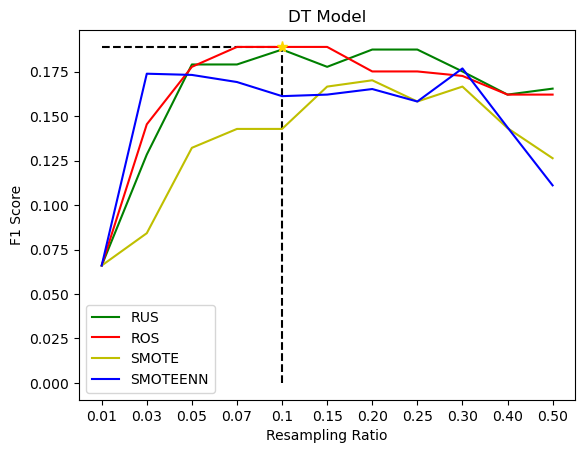

In [29]:
df_DT = df

# Define data values
x = ['0.01', '0.03', '0.05', '0.07', '0.1', '0.15', '0.20', '0.25', '0.30', '0.40', '0.50']
y = df_DT['f1score_under_val'].values
z = df_DT['f1score_over_val'].values
a = df_DT['f1score_smote_val'].values
b = df_DT['f1score_smoteenn_val'].values

# Plot a simple line chart
plt.plot(x, y, 'g', label='RUS')
plt.plot(x, z, 'r', label='ROS')
plt.plot(x, a, 'y', label='SMOTE')
plt.plot(x, b, 'b', label='SMOTEENN')
plt.plot('0.1', max(df_DT['f1score_over_val'].values), marker = '*', ms = 8, mec = 'gold', mfc = 'gold')
plt.hlines(max(df_DT['f1score_over_val'].values), 0, '0.1', color='black', linestyles= 'dashed')  # Stems
plt.vlines('0.1', 0, max(df_DT['f1score_over_val'].values), color='black', linestyles= 'dashed')  # Stems
plt.xlabel("Resampling Ratio")
plt.ylabel("F1 Score")
plt.title("DT Model")
plt.legend()
plt.show()

In [21]:
classifier_base = DecisionTreeClassifier(random_state = 102022)
classifier_tuned = DecisionTreeClassifier(random_state = 102022, class_weight = 'balanced', criterion = 'entropy', max_depth = 3, max_features = 'auto')
classifier_resampled_tuned = DecisionTreeClassifier(random_state = 102022, class_weight = None, criterion = 'entropy', max_depth = 4, max_features = 'auto')

resample = RandomOverSampler(sampling_strategy = 0.1, random_state=102022)
X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

classifier_base.fit(X_train, y_train.values.ravel())
classifier_tuned.fit(X_train, y_train.values.ravel())
classifier_resampled_tuned.fit(X_resampled, y_resampled.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='auto',
                       random_state=102022)

In [22]:
y_train_predict_base = classifier_base.predict(X_train)
y_val_predict_base = classifier_base.predict(X_val)
y_test_predict_base = classifier_base.predict(X_test)
y_train_predict_proba_base = classifier_base.predict_proba(X_train)
y_val_predict_proba_base = classifier_base.predict_proba(X_val)
y_test_predict_proba_base = classifier_base.predict_proba(X_test)

y_train_predict_tuned = classifier_tuned.predict(X_train)
y_val_predict_tuned = classifier_tuned.predict(X_val)
y_test_predict_tuned = classifier_tuned.predict(X_test)
y_train_predict_proba_tuned = classifier_tuned.predict_proba(X_train)
y_val_predict_proba_tuned = classifier_tuned.predict_proba(X_val)
y_test_predict_proba_tuned = classifier_tuned.predict_proba(X_test)

y_train_predict_resampled_tuned = classifier_resampled_tuned.predict(X_train)
y_val_predict_resampled_tuned = classifier_resampled_tuned.predict(X_val)
y_test_predict_resampled_tuned = classifier_resampled_tuned.predict(X_test)
y_train_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_train)
y_val_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_val)
y_test_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_test)

In [23]:
accuracy = accuracy_score(y_val,y_val_predict_base)
precision = precision_score(y_val,y_val_predict_base)
recall = recall_score(y_val,y_val_predict_base)
f1 = f1_score(y_val,y_val_predict_base)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_base[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_base[:,1])
print('Base Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_tuned)
precision = precision_score(y_val,y_val_predict_tuned)
recall = recall_score(y_val,y_val_predict_tuned)
f1 = f1_score(y_val,y_val_predict_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_tuned[:,1])
print('Tuned Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Base Model: 	accuracy: 0.9797 	precision: 0.0471 	recall: 0.0533 	f1: 0.05 	roc_auc: 0.5206 	lift: 0.0
Tuned Model: 	accuracy: 0.834 	precision: 0.035 	recall: 0.5867 	f1: 0.066 	roc_auc: 0.7741 	lift: 16.0
R&T Model: 	accuracy: 0.9863 	precision: 0.2308 	recall: 0.16 	f1: 0.189 	roc_auc: 0.7275 	lift: 16.0


In [25]:
y_val_predict_proba_tuned[:,1]

array([0.28597031, 0.28597031, 0.4818236 , ..., 0.28597031, 0.73248555,
       0.28597031])

In [65]:
print('----------------------------------------------------------------------------------')
cm_base = confusion_matrix(y_val,y_val_predict_base) #Create a confusion matrix of GT labels and predictions
print('CM Base')
print(cm_base)
cm_tuned = confusion_matrix(y_val,y_val_predict_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Tuned')
print(cm_tuned)
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Base
[[7344   81]
 [  71    4]]
----------------------------------------------------------------------------------
CM Tuned
[[6211 1214]
 [  31   44]]
----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7385   40]
 [  63   12]]
----------------------------------------------------------------------------------


Plot PR curves of Resampled & Tuned Model:


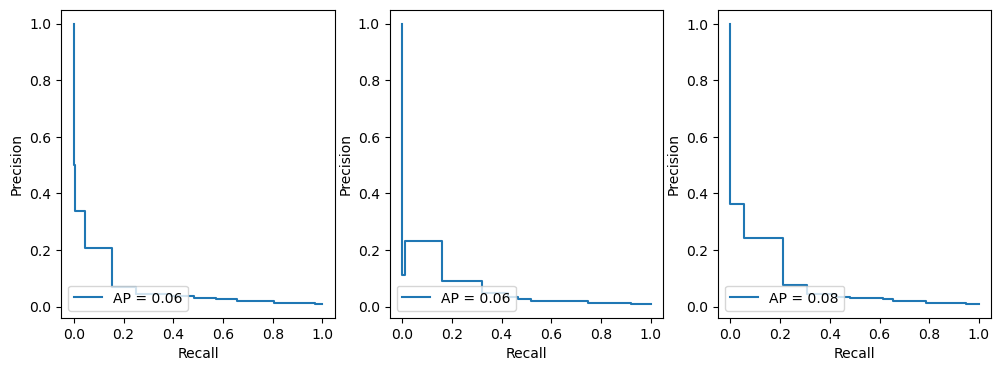

PR_AUC Train: 0.0643 	| PR_AUC Val: 0.0649 	| PR_AUC Test: 0.0828


In [66]:
print('Plot PR curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba_resampled_tuned[:,1])
AP_train = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
PR_curve_train.plot(ax1)
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba_resampled_tuned[:,1])
AP_val = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
PR_curve_val.plot(ax2)
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba_resampled_tuned[:,1])
AP_test = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
PR_curve_test.plot(ax3)
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))

In [70]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned[:,1])
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned[:,1])
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.9857 	precision: 0.2059 	recall: 0.1517 	f1: 0.1747 	roc_auc: 0.7735 	pr_auc: 0.0643 	lift_score: 15.2
R&T Model Val: 		accuracy: 0.9863 	precision: 0.2308 	recall: 0.16 	f1: 0.189 	roc_auc: 0.7275 	pr_auc: 0.0649 	lift_score: 16.0
R&T Model Test: 	accuracy: 0.9855 	precision: 0.2424 	recall: 0.2133 	f1: 0.227 	roc_auc: 0.763 		pr_auc: 0.0828 	lift_score: 21.3


<a id=’b’></a>
## 4. SVM

In [19]:
param_grid={'kernel':['linear', 'rbf', 'sigmoid'], 
            'gamma':  ['scale','auto'],
            'class_weight': [None, 'balanced']}
df = pd.DataFrame()
df['ratio'] = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

for y in [0,1,2,3]:
    if y == 0:
        print('Undersampling Gridsearch:')
    elif y == 1:
        print('Oversampling Gridsearch:')
    elif y == 2:
        print('SMOTE Gridsearch:')
    else:
        print('SMOTEENN Gridsearch:')
    for x in range(0,(df.shape[0])):

        if x == 0:
            X_train_subsampled, X_test_subsampled, y_train_subsampled, y_test_subsampled = train_test_split(X_train, y_train, stratify=y_train, test_size=0.75, random_state= 102022)
            X_gridsearch = X_train_subsampled.append(X_val)
            y_gridsearch = y_train_subsampled.append(y_val)
            split_index = [-1 if x in X_train_subsampled.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = SVC(random_state = 102022)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1', n_jobs = -1)
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_train_subsampled,y_train_subsampled.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
        
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)

            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)

            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)

            print("Resample ratio :", df.loc[x].values[0], " \t| tuned hpyerparameters:", gridsearch.best_params_, " \t| f1-score :", round(gridsearch.best_score_,4) )
        else:
            if y == 0:
                resample = RandomUnderSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 1:
                resample = RandomOverSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 2:
                resample = SMOTE(sampling_strategy = df.loc[x].values[0], random_state=102022)
            else:
                resample = SMOTEENN(sampling_strategy = df.loc[x].values[0], random_state=102022)

            X_train_subsampled, X_test_subsampled, y_train_subsampled, y_test_subsampled = train_test_split(X_train, y_train, stratify=y_train, test_size=0.75, random_state= 102022)    
            X_resampled, y_resampled = resample.fit_resample(X_train_subsampled, y_train_subsampled)
            X_gridsearch = X_resampled.append(X_val)
            y_gridsearch = y_resampled.append(y_val)
            # Create a list where train data indices are -1 and validation data indices are 0
            split_index = [-1 if x in X_resampled.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = SVC(random_state = 102022)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1',n_jobs = -1)

            # Fit with all data
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_resampled,y_resampled.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)

            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
       
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)

            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)

            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)

                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)

                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)

            
            print("Resample ratio:", df.loc[x].values[0], " \t| tuned hpyerparameters:", gridsearch.best_params_, " \t| f1-score_val:", round(gridsearch.best_score_,4) )


Undersampling Gridsearch:
Resample ratio : 0.01  	| tuned hpyerparameters: {'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}  	| f1-score : 0.0574
Resample ratio: 0.03  	| tuned hpyerparameters: {'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}  	| f1-score_val: 0.0574
Resample ratio: 0.05  	| tuned hpyerparameters: {'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}  	| f1-score_val: 0.0609
Resample ratio: 0.07  	| tuned hpyerparameters: {'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}  	| f1-score_val: 0.0618
Resample ratio: 0.1  	| tuned hpyerparameters: {'class_weight': None, 'gamma': 'auto', 'kernel': 'sigmoid'}  	| f1-score_val: 0.0759
Resample ratio: 0.15  	| tuned hpyerparameters: {'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}  	| f1-score_val: 0.1611
Resample ratio: 0.2  	| tuned hpyerparameters: {'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}  	| f1-score_val: 0.1317
Resample ratio: 0.25  	|

In [20]:
df.head()

,ratio,precision_under_train,recall_under_train,f1score_under_train,precision_under_val,recall_under_val,f1score_under_val,precision_under_test,recall_under_test,f1score_under_test,...,f1score_smote_test,precision_smoteenn_train,recall_smoteenn_train,f1score_smoteenn_train,precision_smoteenn_val,recall_smoteenn_val,f1score_smoteenn_val,precision_smoteenn_test,recall_smoteenn_test,f1score_smoteenn_test
0,0.01,0.028716,0.746667,0.055305,0.029798,0.786667,0.057421,0.029851,0.80,0.057554,...,0.057554,0.028716,0.746667,0.055305,0.029798,0.786667,0.057421,0.029851,0.800000,0.057554
1,0.03,0.028916,0.751667,0.055689,0.029789,0.773333,0.057369,0.029895,0.80,0.057637,...,0.055451,0.172973,0.106667,0.131959,0.097561,0.053333,0.068966,0.169811,0.120000,0.140625
2,0.05,0.040047,0.618333,0.075223,0.032428,0.493333,0.060855,0.030329,0.48,0.057052,...,0.055046,0.196721,0.120000,0.149068,0.166667,0.080000,0.108108,0.261905,0.146667,0.188034
3,0.07,0.039169,0.631667,0.073764,0.032814,0.533333,0.061824,0.033493,0.56,0.063205,...,0.135922,0.145078,0.186667,0.163265,0.146341,0.160000,0.152866,0.183673,0.240000,0.208092
4,0.10,0.069335,0.161667,0.097049,0.055556,0.120000,0.075949,0.075377,0.20,0.109489,...,0.208092,0.144703,0.186667,0.163028,0.144578,0.160000,0.151899,0.183673,0.240000,0.208092


In [21]:
df.loc[5,['ratio','f1score_under_train', 'f1score_under_val', 'f1score_under_test']].head()

ratio                  0.150000
f1score_under_train    0.158610
f1score_under_val      0.161074
f1score_under_test     0.196319
Name: 5, dtype: float64

In [22]:
df.to_pickle('SVM_Gridsearch_df.pkl')

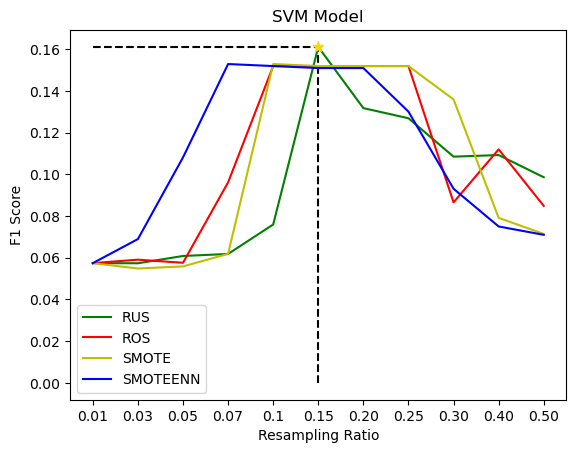

In [23]:
df_SVM = df

# Define data values
x = ['0.01', '0.03', '0.05', '0.07', '0.1', '0.15', '0.20', '0.25', '0.30', '0.40', '0.50']
y = df_SVM['f1score_under_val'].values
z = df_SVM['f1score_over_val'].values
a = df_SVM['f1score_smote_val'].values
b = df_SVM['f1score_smoteenn_val'].values

# Plot a simple line chart
plt.plot(x, y, 'g', label='RUS')
plt.plot(x, z, 'r', label='ROS')
plt.plot(x, a, 'y', label='SMOTE')
plt.plot(x, b, 'b', label='SMOTEENN')
plt.plot('0.15', max(df_SVM['f1score_under_val'].values), marker = '*', ms = 8, mec = 'gold', mfc = 'gold')
plt.hlines(max(df_SVM['f1score_under_val'].values), 0, '0.15', color='black', linestyles= 'dashed')  # Stems
plt.vlines('0.15', 0, max(df_SVM['f1score_under_val'].values), color='black', linestyles= 'dashed')  # Stems
plt.xlabel("Resampling Ratio")
plt.ylabel("F1 Score")
plt.title("SVM Model")
plt.legend()
plt.show()

In [26]:
classifier_base = SVC(random_state = 102022, probability = True)
classifier_tuned = SVC(random_state = 102022, class_weight = 'balanced', gamma = 'scale', kernel = 'linear', probability = True)
classifier_resampled_tuned = SVC(random_state = 102022, class_weight = None, gamma = 'scale', kernel = 'linear', probability = True)

resample = RandomUnderSampler(sampling_strategy = 0.15, random_state=102022)
X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

classifier_base.fit(X_train, y_train.values.ravel())
classifier_tuned.fit(X_train, y_train.values.ravel())
classifier_resampled_tuned.fit(X_resampled, y_resampled.values.ravel())

SVC(kernel='linear', probability=True, random_state=102022)

In [27]:
y_train_predict_base = classifier_base.predict(X_train)
y_val_predict_base = classifier_base.predict(X_val)
y_test_predict_base = classifier_base.predict(X_test)
y_train_predict_proba_base = classifier_base.predict_proba(X_train)
y_val_predict_proba_base = classifier_base.predict_proba(X_val)
y_test_predict_proba_base = classifier_base.predict_proba(X_test)

y_train_predict_tuned = classifier_tuned.predict(X_train)
y_val_predict_tuned = classifier_tuned.predict(X_val)
y_test_predict_tuned = classifier_tuned.predict(X_test)
y_train_predict_proba_tuned = classifier_tuned.predict_proba(X_train)
y_val_predict_proba_tuned = classifier_tuned.predict_proba(X_val)
y_test_predict_proba_tuned = classifier_tuned.predict_proba(X_test)

y_train_predict_resampled_tuned = classifier_resampled_tuned.predict(X_train)
y_val_predict_resampled_tuned = classifier_resampled_tuned.predict(X_val)
y_test_predict_resampled_tuned = classifier_resampled_tuned.predict(X_test)
y_train_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_train)
y_val_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_val)
y_test_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_test)

In [28]:
accuracy = accuracy_score(y_val,y_val_predict_base)
precision = precision_score(y_val,y_val_predict_base)
recall = recall_score(y_val,y_val_predict_base)
f1 = f1_score(y_val,y_val_predict_base)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_base[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_base[:,1])
print('Base Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_tuned)
precision = precision_score(y_val,y_val_predict_tuned)
recall = recall_score(y_val,y_val_predict_tuned)
f1 = f1_score(y_val,y_val_predict_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_tuned[:,1])
print('Tuned Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Base Model: 	accuracy: 0.99 	precision: 0.0 	recall: 0.0 	f1: 0.0 	roc_auc: 0.6576 	lift: 14.7
Tuned Model: 	accuracy: 0.7628 	precision: 0.0293 	recall: 0.7067 	f1: 0.0562 	roc_auc: 0.8107 	lift: 13.3
R&T Model: 	accuracy: 0.9835 	precision: 0.1644 	recall: 0.16 	f1: 0.1622 	roc_auc: 0.753 	lift: 16.0


c:\Users\ahmet\anaconda3\envs\DL\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print('----------------------------------------------------------------------------------')
cm_base = confusion_matrix(y_val,y_val_predict_base) #Create a confusion matrix of GT labels and predictions
print('CM Base')
print(cm_base)
cm_tuned = confusion_matrix(y_val,y_val_predict_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Tuned')
print(cm_tuned)
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Base
[[7425    0]
 [  75    0]]
----------------------------------------------------------------------------------
CM Tuned
[[5668 1757]
 [  22   53]]
----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7364   61]
 [  63   12]]
----------------------------------------------------------------------------------


Plot PR curves of Resampled & Tuned Model:


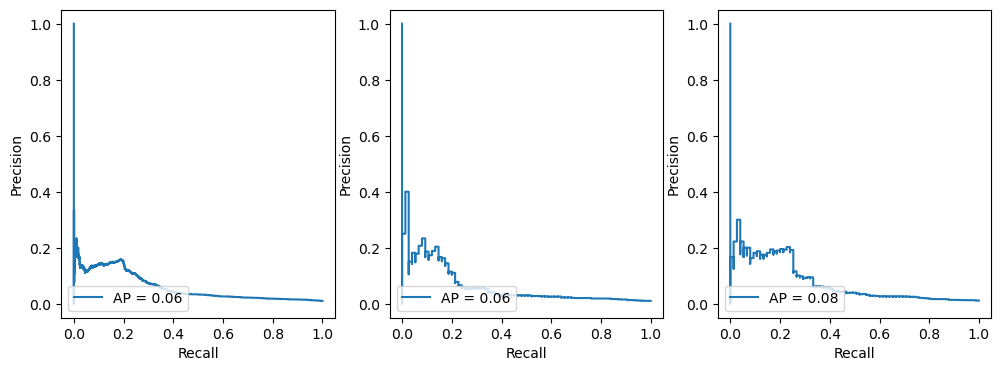

PR_AUC Train: 0.0594 	| PR_AUC Val: 0.0634 	| PR_AUC Test: 0.0771


In [16]:
print('Plot PR curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba_resampled_tuned[:,1])
AP_train = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
PR_curve_train.plot(ax1)
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba_resampled_tuned[:,1])
AP_val = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
PR_curve_val.plot(ax2)
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba_resampled_tuned[:,1])
AP_test = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
PR_curve_test.plot(ax3)
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))

In [35]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned[:,1])
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned[:,1])
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.9818 	precision: 0.1569 	recall: 0.1867 	f1: 0.1705 	roc_auc: 0.7697 	pr_auc: 0.0594 	lift_score: 14.5
R&T Model Val: 		accuracy: 0.9835 	precision: 0.1644 	recall: 0.16 	f1: 0.1622 	roc_auc: 0.753 		pr_auc: 0.0634 	lift_score: 16.0
R&T Model Test: 	accuracy: 0.9829 	precision: 0.2022 	recall: 0.24 	f1: 0.2195 	roc_auc: 0.7779 	pr_auc: 0.0771 	lift_score: 18.7


<a id=’b’></a>
## 5. LightGBM

In [30]:
param_grid = {'is_unbalance': [True,False], 
              'max_depth':[2, 3, 4], 
              'learning_rate': [0.005, 0.01, 0.1],
              'min_child_samples': [50, 100, 150],
              'reg_alpha': [0.25, 0.5, 1],
              'reg_lambda': [0.25, 0.5, 1]}
df = pd.DataFrame()
df['ratio'] = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

for y in [0,1,2,3]:
    if y == 0:
        print('Undersampling Gridsearch:')
    elif y == 1:
        print('Oversampling Gridsearch:')
    elif y == 2:
        print('SMOTE Gridsearch:')
    else:
        print('SMOTEENN Gridsearch:')
    for x in range(0,(df.shape[0])):

        if x == 0:
            X_gridsearch = X_train.append(X_val)
            y_gridsearch = y_train.append(y_val)
            split_index = [-1 if x in X_train.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = LGBMClassifier(random_state = 102022)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1', n_jobs = -1)
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_train,y_train.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            y_train_predict_proba = classifier_base.predict_proba(X_train)
            y_val_predict_proba = classifier_base.predict_proba(X_val)
            y_test_predict_proba = classifier_base.predict_proba(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            print("Resample ratio:", df.loc[x].values[0], " \t|tuned hp:", gridsearch.best_params_, " \t|f1-score_val:", round(gridsearch.best_score_,4))
        else:
            if y == 0:
                resample = RandomUnderSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 1:
                resample = RandomOverSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 2:
                resample = SMOTE(sampling_strategy = df.loc[x].values[0], random_state=102022)
            else:
                resample = SMOTEENN(sampling_strategy = df.loc[x].values[0], random_state=102022)
            X_resampled, y_resampled = resample.fit_resample(X_train, y_train)
            X_gridsearch = X_resampled.append(X_val)
            y_gridsearch = y_resampled.append(y_val)
            # Create a list where train data indices are -1 and validation data indices are 0
            split_index = [-1 if x in X_resampled.index else 0 for x in X_gridsearch.index]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)
            # Use PredefinedSplit in GridSearchCV
            classifier_base = LGBMClassifier(random_state = 102022)
            gridsearch = GridSearchCV(estimator = classifier_base,
                                    cv=pds,
                                    param_grid=param_grid,
                                    scoring = 'f1', n_jobs = -1)

            # Fit with all data
            gridsearch.fit(X_gridsearch, y_gridsearch.values.ravel())
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_resampled,y_resampled.values.ravel())
            y_train_predict = classifier_base.predict(X_train)
            y_val_predict = classifier_base.predict(X_val)
            y_test_predict = classifier_base.predict(X_test)
            y_train_predict_proba = classifier_base.predict_proba(X_train)
            y_val_predict_proba = classifier_base.predict_proba(X_val)
            y_test_predict_proba = classifier_base.predict_proba(X_test)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test, y_test_predict_proba[:,1])
            
            print("Resample ratio:", df.loc[x].values[0], " \t|tuned hp:", gridsearch.best_params_, " \t|f1-score_val:", round(gridsearch.best_score_,4))


Undersampling Gridsearch:
Resample ratio: 0.01  	|tuned hp: {'is_unbalance': True, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 50, 'reg_alpha': 0.5, 'reg_lambda': 0.5}  	|f1-score_val: 0.1863
Resample ratio: 0.03  	|tuned hp: {'is_unbalance': True, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 50, 'reg_alpha': 0.25, 'reg_lambda': 0.25}  	|f1-score_val: 0.2065
Resample ratio: 0.05  	|tuned hp: {'is_unbalance': True, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 100, 'reg_alpha': 0.5, 'reg_lambda': 0.5}  	|f1-score_val: 0.2078
Resample ratio: 0.07  	|tuned hp: {'is_unbalance': True, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 50, 'reg_alpha': 0.25, 'reg_lambda': 0.25}  	|f1-score_val: 0.1887
Resample ratio: 0.1  	|tuned hp: {'is_unbalance': True, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_samples': 100, 'reg_alpha': 0.25, 'reg_lambda': 0.25}  	|f1-score_val: 0.1892
Resample ratio: 0.15  	|tuned hp: {'is_unbalance': False,

In [31]:
df.head()

,ratio,precision_under_train,recall_under_train,f1score_under_train,rocauc_under_train,prauc_under_train,precision_under_val,recall_under_val,f1score_under_val,rocauc_under_val,...,precision_smoteenn_val,recall_smoteenn_val,f1score_smoteenn_val,rocauc_smoteenn_val,prauc_smoteenn_val,precision_smoteenn_test,recall_smoteenn_test,f1score_smoteenn_test,rocauc_smoteenn_test,prauc_smoteenn_test
0,0.01,0.181696,0.225000,0.201042,0.865002,0.136880,0.174419,0.200000,0.186335,0.839319,...,0.174419,0.200000,0.186335,0.839319,0.095783,0.186275,0.253333,0.214689,0.857261,0.126360
1,0.03,0.187406,0.208333,0.197316,0.853307,0.116890,0.200000,0.213333,0.206452,0.831947,...,0.185185,0.200000,0.192308,0.817956,0.071741,0.168421,0.213333,0.188235,0.851465,0.106077
2,0.05,0.176385,0.201667,0.188180,0.845754,0.111645,0.202532,0.213333,0.207792,0.826981,...,0.194030,0.173333,0.183099,0.813804,0.072724,0.213333,0.213333,0.213333,0.857370,0.097344
3,0.07,0.173184,0.206667,0.188450,0.842528,0.102970,0.178571,0.200000,0.188679,0.822091,...,0.235294,0.160000,0.190476,0.775069,0.072181,0.210526,0.213333,0.211921,0.821150,0.096863
4,0.10,0.175911,0.185000,0.180341,0.811632,0.081020,0.191781,0.186667,0.189189,0.804623,...,0.214286,0.160000,0.183206,0.774304,0.074703,0.217949,0.226667,0.222222,0.820208,0.115422


In [32]:
df[['ratio','prauc_over_train', 'prauc_over_val', 'prauc_over_test']].head()

,ratio,prauc_over_train,prauc_over_val,prauc_over_test
0,0.01,0.136880,0.095783,0.126360
1,0.03,0.119256,0.086080,0.113574
2,0.05,0.122491,0.083222,0.100973
3,0.07,0.120354,0.078551,0.117126
4,0.10,0.191225,0.094010,0.115226


In [33]:
df.loc[2,['ratio','f1score_under_train', 'f1score_under_val', 'f1score_under_test']].head()

ratio                  0.050000
f1score_under_train    0.188180
f1score_under_val      0.207792
f1score_under_test     0.219512
Name: 2, dtype: float64

In [34]:
df.to_pickle('LightGBM_Gridsearch_df.pkl')

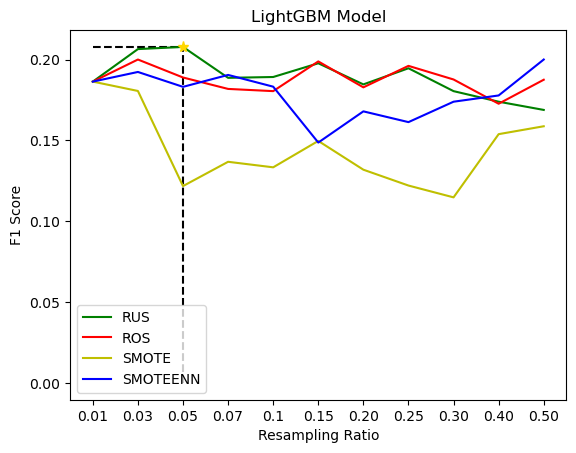

In [35]:
df_LGBM = df

# Define data values
x = ['0.01', '0.03', '0.05', '0.07', '0.1', '0.15', '0.20', '0.25', '0.30', '0.40', '0.50']
y = df_LGBM['f1score_under_val'].values
z = df_LGBM['f1score_over_val'].values
a = df_LGBM['f1score_smote_val'].values
b = df_LGBM['f1score_smoteenn_val'].values

# Plot a simple line chart
plt.plot(x, y, 'g', label='RUS')
plt.plot(x, z, 'r', label='ROS')
plt.plot(x, a, 'y', label='SMOTE')
plt.plot(x, b, 'b', label='SMOTEENN')
plt.plot('0.05', max(df_LGBM['f1score_under_val'].values), marker = '*', ms = 8, mec = 'gold', mfc = 'gold')
plt.hlines(max(df_LGBM['f1score_under_val'].values), 0, '0.05', color='black', linestyles= 'dashed')  # Stems
plt.vlines('0.05', 0, max(df_LGBM['f1score_under_val'].values), color='black', linestyles= 'dashed')  # Stems
plt.xlabel("Resampling Ratio")
plt.ylabel("F1 Score")
plt.title("LightGBM Model")
plt.legend()
plt.show()

In [86]:
classifier_base = LGBMClassifier(random_state = 102022)
classifier_tuned = LGBMClassifier(random_state = 102022, is_unbalance = True, learning_rate = 0.01, max_depth = 3, min_child_samples = 50, reg_alpha = 0.5, reg_lambda = 0.5)
classifier_resampled_tuned = LGBMClassifier(random_state = 102022, is_unbalance = True, learning_rate = 0.01, max_depth = 3, min_child_samples = 100, reg_alpha = 0.5, reg_lambda = 0.5)

resample = RandomUnderSampler(sampling_strategy = 0.05, random_state=102022)
X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

classifier_base.fit(X_train, y_train.values.ravel())
classifier_tuned.fit(X_train, y_train.values.ravel())
classifier_resampled_tuned.fit(X_resampled, y_resampled.values.ravel())

LGBMClassifier(is_unbalance=True, learning_rate=0.01, max_depth=3,
               min_child_samples=100, random_state=102022, reg_alpha=0.5,
               reg_lambda=0.5)

In [87]:
y_train_predict_base = classifier_base.predict(X_train)
y_val_predict_base = classifier_base.predict(X_val)
y_test_predict_base = classifier_base.predict(X_test)
y_train_predict_proba_base = classifier_base.predict_proba(X_train)
y_val_predict_proba_base = classifier_base.predict_proba(X_val)
y_test_predict_proba_base = classifier_base.predict_proba(X_test)

y_train_predict_tuned = classifier_tuned.predict(X_train)
y_val_predict_tuned = classifier_tuned.predict(X_val)
y_test_predict_tuned = classifier_tuned.predict(X_test)
y_train_predict_proba_tuned = classifier_tuned.predict_proba(X_train)
y_val_predict_proba_tuned = classifier_tuned.predict_proba(X_val)
y_test_predict_proba_tuned = classifier_tuned.predict_proba(X_test)

y_train_predict_resampled_tuned = classifier_resampled_tuned.predict(X_train)
y_val_predict_resampled_tuned = classifier_resampled_tuned.predict(X_val)
y_test_predict_resampled_tuned = classifier_resampled_tuned.predict(X_test)
y_train_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_train)
y_val_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_val)
y_test_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_test)

In [88]:
ds = pd.DataFrame(y_train_predict_resampled_tuned)
ds.to_pickle('./LGBM predictions/y_train_predict.pkl')
ds = pd.DataFrame(y_val_predict_resampled_tuned)
ds.to_pickle('./LGBM predictions/y_val_predict.pkl')
ds = pd.DataFrame(y_test_predict_resampled_tuned)
ds.to_pickle('./LGBM predictions/y_test_predict.pkl')
ds = pd.DataFrame(y_train_predict_proba_resampled_tuned)
ds.to_pickle('./LGBM predictions/y_train_predict_proba.pkl')
ds = pd.DataFrame(y_val_predict_proba_resampled_tuned)
ds.to_pickle('./LGBM predictions/y_val_predict_proba.pkl')
ds = pd.DataFrame(y_test_predict_proba_resampled_tuned)
ds.to_pickle('./LGBM predictions/y_test_predict_proba.pkl')

In [83]:
accuracy = accuracy_score(y_val,y_val_predict_base)
precision = precision_score(y_val,y_val_predict_base)
recall = recall_score(y_val,y_val_predict_base)
f1 = f1_score(y_val,y_val_predict_base)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_base[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_base[:,1])
print('Base Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_tuned)
precision = precision_score(y_val,y_val_predict_tuned)
recall = recall_score(y_val,y_val_predict_tuned)
f1 = f1_score(y_val,y_val_predict_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_tuned[:,1])
print('Tuned Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Base Model: 	accuracy: 0.9887 	precision: 0.1429 	recall: 0.0267 	f1: 0.0449 	roc_auc: 0.8251 	lift: 13.3
Tuned Model: 	accuracy: 0.9825 	precision: 0.1744 	recall: 0.2 	f1: 0.1863 	roc_auc: 0.8393 	lift: 17.3
R&T Model: 	accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 	lift: 18.7


In [84]:
print('----------------------------------------------------------------------------------')
cm_base = confusion_matrix(y_val,y_val_predict_base) #Create a confusion matrix of GT labels and predictions
print('CM Base')
print(cm_base)
cm_tuned = confusion_matrix(y_val,y_val_predict_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Tuned')
print(cm_tuned)
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Base
[[7413   12]
 [  73    2]]
----------------------------------------------------------------------------------
CM Tuned
[[7354   71]
 [  60   15]]
----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7362   63]
 [  59   16]]
----------------------------------------------------------------------------------


Plot PR curves of Resampled & Tuned Model:


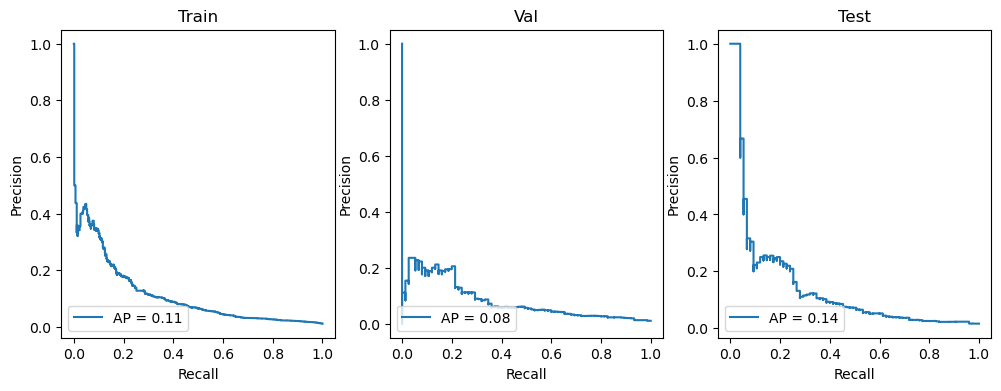

PR_AUC Train: 0.1116 	| PR_AUC Val: 0.081 	| PR_AUC Test: 0.1438


In [85]:
print('Plot PR curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba_resampled_tuned[:,1])
AP_train = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
PR_curve_train.plot(ax1)
ax1.set_title("Train")
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba_resampled_tuned[:,1])
AP_val = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
PR_curve_val.plot(ax2)
ax2.set_title("Val")
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba_resampled_tuned[:,1])
AP_test = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
PR_curve_test.plot(ax3)
ax3.set_title("Test")
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))

In [61]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned[:,1])
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned[:,1])
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.9826 	precision: 0.1764 	recall: 0.2017 	f1: 0.1882 	roc_auc: 0.8458 	pr_auc: 0.1116 	lift_score: 18.7
R&T Model Val: 		accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 		pr_auc: 0.081 	lift_score: 18.7
R&T Model Test: 	accuracy: 0.9829 	precision: 0.2022 	recall: 0.24 	f1: 0.2195 	roc_auc: 0.8548 	pr_auc: 0.1438 	lift_score: 22.7


<a id=’c’></a>
## 6. FCNN

In [8]:
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)

In [9]:
class FCNN(nn.Module):
    def __init__(self, feature_size = 33,
            activation = F.relu,
            dropout_rate = 0.5,
            dense1_size = 64,
            dense2_size = 64,
            dense3_size = 32,
            batch_norm = True):
        super(FCNN, self).__init__()

        self.dense1 = nn.Linear(feature_size, dense1_size)
        self.bn1 = nn.BatchNorm1d(dense1_size)
        self.do1 = nn.Dropout(dropout_rate)
        self.dense2 = nn.Linear(dense1_size, dense2_size)
        self.bn2 = nn.BatchNorm1d(dense2_size)
        self.do2 = nn.Dropout(dropout_rate)
        self.dense3 = nn.Linear(dense2_size, dense3_size)
        self.bn3 = nn.BatchNorm1d(dense3_size)
        self.do3 = nn.Dropout(dropout_rate)
        self.dense4 = nn.Linear(dense3_size, 2)
        self.activation = activation
        self.batch_norm = batch_norm
        self.initialize_weights()
    
    def forward(self, x):
        if self.batch_norm:
            x = F.relu(self.do1(self.bn1(self.dense1(x))))
            x = F.relu(self.do2(self.bn2(self.dense2(x))))
            x = F.relu(self.do3(self.bn3(self.dense3(x))))
            x = F.softmax(self.dense4(x), dim = -1)
        else:
            x = F.relu(self.do1(self.dense1(x)))
            x = F.relu(self.do2(self.dense2(x)))
            x = F.relu(self.do3(self.dense3(x)))
            x = F.softmax(self.dense4(x), dim = -1)    

        return x
    
    def initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, nn.init.calculate_gain('relu'))
                nn.init.constant_(m.bias, 0)


In [11]:
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.dataset import Dataset

X_train_torch = torch.tensor(X_train.values, dtype = torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype = torch.int64).reshape(-1)

X_val_torch = torch.tensor(X_val.values, dtype = torch.float32)
y_val_torch = torch.tensor(y_val.values, dtype = torch.int64).reshape(-1)

X_test_torch = torch.tensor(X_test.values, dtype = torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype = torch.int64).reshape(-1)

valid_ds = Dataset(X_val_torch, y_val_torch)

In [12]:
net = NeuralNetClassifier(
    FCNN,
    max_epochs=10,
    lr=0.1,
    batch_size = 64,
    train_split = predefined_split(valid_ds),
    callbacks=[f1],
    iterator_train__shuffle=True,
    verbose=0,
    criterion = nn.NLLLoss(weight = torch.Tensor([0.01, 0.99])),
    device='cuda',  # uncomment this to train with CUDA
)

In [13]:
params = {
    'max_epochs': [20, 30, 40],
    'lr': [0.005, 0.01, 0.05],
    'batch_size' : [32],
    #'criterion' : [nn.NLLLoss(weight = torch.Tensor([0.01, 0.99])), nn.NLLLoss],
    'module__activation': [F.relu, F.leaky_relu],
    #'module__dropout_rate': [0, 0.25, 0.5],
    #'module__dense1_size': [64, 128],
    #'module__dense2_size': [32, 64],
    #'module__dense3_size': [16, 32],
    #'module__batch_norm': [True, False],
}

In [15]:
gridsearch = GridSearchCV(net, params, cv=pds, scoring='f1', verbose=2)

In [16]:
gridsearch.fit(X_gridsearch, y_gridsearch)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END batch_size=32, lr=0.005, max_epochs=20, module__activation=<function relu at 0x000002642A38DCA0>; total time= 2.6min
[CV] END batch_size=32, lr=0.005, max_epochs=20, module__activation=<function leaky_relu at 0x000002642A38F0D0>; total time= 2.6min
[CV] END batch_size=32, lr=0.005, max_epochs=30, module__activation=<function relu at 0x000002642A38DCA0>; total time= 4.4min
[CV] END batch_size=32, lr=0.005, max_epochs=30, module__activation=<function leaky_relu at 0x000002642A38F0D0>; total time= 4.7min
[CV] END batch_size=32, lr=0.005, max_epochs=40, module__activation=<function relu at 0x000002642A38DCA0>; total time= 6.3min
[CV] END batch_size=32, lr=0.005, max_epochs=40, module__activation=<function leaky_relu at 0x000002642A38F0D0>; total time= 6.0min
[CV] END batch_size=32, lr=0.01, max_epochs=20, module__activation=<function relu at 0x000002642A38DCA0>; total time= 2.8min
[CV] END batch_size=32, lr=0.01, max_epo

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.FCNN'>,
),
             param_grid={'batch_size': [32, 128], 'lr': [0.005, 0.01, 0.05],
                         'max_epochs': [20, 30, 40],
                         'module__activation': [<function relu at 0x000002642A38DCA0>,
                                                <function leaky_relu at 0x000002642A38F0D0>]},
             scoring='f1', verbose=2)

In [32]:
gridsearch.best_params_

{'batch_size': 32,
 'lr': 0.05,
 'max_epochs': 30,
 'module__activation': <function torch.nn.functional.leaky_relu(input: torch.Tensor, negative_slope: float = 0.01, inplace: bool = False) -> torch.Tensor>}

In [34]:
gridsearch.best_score_

0.16049382716049382

In [36]:
params2 = {
    'max_epochs': [30],
    'lr': [0.05],
    'batch_size' : [32],
    #'criterion' : [nn.NLLLoss(weight = torch.Tensor([0.01, 0.99]))],
    'module__activation': [F.leaky_relu],
    'module__dropout_rate': [0, 0.25, 0.5],
    'module__dense1_size': [64, 128],
    'module__dense2_size': [32, 64],
    'module__dense3_size': [16, 32],
    'module__batch_norm': [True, False]
}

In [37]:
gridsearch = GridSearchCV(net, params2, cv=pds, scoring='f1', verbose=2)
gridsearch.fit(X_gridsearch, y_gridsearch)

Fitting 1 folds for each of 48 candidates, totalling 48 fits
[CV] END batch_size=32, lr=0.05, max_epochs=30, module__activation=<function leaky_relu at 0x000002642A38F0D0>, module__batch_norm=True, module__dense1_size=64, module__dense2_size=32, module__dense3_size=16, module__dropout_rate=0; total time= 3.4min
[CV] END batch_size=32, lr=0.05, max_epochs=30, module__activation=<function leaky_relu at 0x000002642A38F0D0>, module__batch_norm=True, module__dense1_size=64, module__dense2_size=32, module__dense3_size=16, module__dropout_rate=0.25; total time= 3.6min
[CV] END batch_size=32, lr=0.05, max_epochs=30, module__activation=<function leaky_relu at 0x000002642A38F0D0>, module__batch_norm=True, module__dense1_size=64, module__dense2_size=32, module__dense3_size=16, module__dropout_rate=0.5; total time= 3.7min
[CV] END batch_size=32, lr=0.05, max_epochs=30, module__activation=<function leaky_relu at 0x000002642A38F0D0>, module__batch_norm=True, module__dense1_size=64, module__dense2_si

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.FCNN'>,
),
             param_grid={'batch_size': [32], 'lr': [0.05], 'max_epochs': [30],
                         'module__activation': [<function leaky_relu at 0x000002642A38F0D0>],
                         'module__batch_norm': [True, False],
                         'module__dense1_size': [64, 128],
                         'module__dense2_size': [32, 64],
                         'module__dense3_size': [16, 32],
                         'module__dropout_rate': [0, 0.25, 0.5]},
             scoring='f1', verbose=2)

In [38]:
gridsearch.best_params_

{'batch_size': 32,
 'lr': 0.05,
 'max_epochs': 30,
 'module__activation': <function torch.nn.functional.leaky_relu(input: torch.Tensor, negative_slope: float = 0.01, inplace: bool = False) -> torch.Tensor>,
 'module__batch_norm': True,
 'module__dense1_size': 128,
 'module__dense2_size': 64,
 'module__dense3_size': 32,
 'module__dropout_rate': 0.25}

In [39]:
gridsearch.best_score_

0.17419354838709677

In [46]:
class FCNN2(nn.Module):
    def __init__(self, feature_size = 33,
            activation = F.leaky_relu,
            dropout_rate = 0.25,
            dense1_size = 128,
            dense2_size = 64,
            dense3_size = 32,
            batch_norm = True):
        super(FCNN2, self).__init__()

        self.dense1 = nn.Linear(feature_size, dense1_size)
        self.bn1 = nn.BatchNorm1d(dense1_size)
        self.do1 = nn.Dropout(dropout_rate)
        self.dense2 = nn.Linear(dense1_size, dense2_size)
        self.bn2 = nn.BatchNorm1d(dense2_size)
        self.do2 = nn.Dropout(dropout_rate)
        self.dense3 = nn.Linear(dense2_size, dense3_size)
        self.bn3 = nn.BatchNorm1d(dense3_size)
        self.do3 = nn.Dropout(dropout_rate)
        self.dense4 = nn.Linear(dense3_size, 2)
        self.activation = activation
        self.batch_norm = batch_norm
        self.initialize_weights()
    
    def forward(self, x):
        if self.batch_norm:
            
            try:
                x = F.relu(self.do1(self.bn1(self.dense1(x))))
                x = F.relu(self.do2(self.bn2(self.dense2(x))))
                x = F.relu(self.do3(self.bn3(self.dense3(x))))
            except:
                self.bn1.eval()
                self.bn2.eval()
                self.bn3.eval()
                x = F.relu(self.do1(self.bn1(self.dense1(x))))
                x = F.relu(self.do2(self.bn2(self.dense2(x))))
                x = F.relu(self.do3(self.bn3(self.dense3(x))))
            x = F.softmax(self.dense4(x), dim = -1)
        else:
            x = F.relu(self.do1(self.dense1(x)))
            x = F.relu(self.do2(self.dense2(x)))
            x = F.relu(self.do3(self.dense3(x)))
            x = F.softmax(self.dense4(x), dim = -1)    

        return x
    
    def initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, nn.init.calculate_gain('relu'))
                nn.init.constant_(m.bias, 0)


In [22]:
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_base = NeuralNetClassifier(FCNN2,
                                                  max_epochs=30,
                                                  lr=0.05,
                                                  batch_size = 32,
                                                  train_split = predefined_split(valid_ds),
                                                  iterator_train__shuffle=True,
                                                  verbose=1,
                                                  criterion = nn.NLLLoss(weight = torch.Tensor([0.01, 0.99])),
                                                  device='cuda'
                                                  )

In [23]:
classifier_base.fit(X_train_torch,y_train_torch)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4590       0.9552        0.4269  8.0589


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=FCNN2(
    (dense1): Linear(in_features=33, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.25, inplace=False)
    (dense2): Linear(in_features=128, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.25, inplace=False)
    (dense3): Linear(in_features=64, out_features=32, bias=True)
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do3): Dropout(p=0.25, inplace=False)
    (dense4): Linear(in_features=32, out_features=2, bias=True)
  ),
)

In [19]:
classifier_base.fit(X_train_torch,y_train_torch)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4590       0.9552        0.4269  8.2335
      2        0.4176       0.9737        0.4221  7.5339


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=FCNN2(
    (dense1): Linear(in_features=33, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.25, inplace=False)
    (dense2): Linear(in_features=128, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.25, inplace=False)
    (dense3): Linear(in_features=64, out_features=32, bias=True)
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do3): Dropout(p=0.25, inplace=False)
    (dense4): Linear(in_features=32, out_features=2, bias=True)
  ),
)

In [14]:
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [ ]:
param_grid = {#'max_epochs': [20, 30, 40],
             'lr': [0.01, 0.05, 0.1],
             #'batch_size' : [32, 64]
             }
df = pd.DataFrame()
df['ratio'] = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]

for y in [0,1,2,3]:
    if y == 0:
        print('Undersampling Gridsearch:')
    elif y == 1:
        print('Oversampling Gridsearch:')
    elif y == 2:
        print('SMOTE Gridsearch:')
    else:
        print('SMOTEENN Gridsearch:')
    for x in range(0,(df.shape[0])):

        if x == 0:
            X_train_torch = torch.tensor(X_train.values, dtype = torch.float32)
            y_train_torch = torch.tensor(y_train.values, dtype = torch.int64).reshape(-1)

            X_val_torch = torch.tensor(X_val.values, dtype = torch.float32)
            y_val_torch = torch.tensor(y_val.values, dtype = torch.int64).reshape(-1)

            X_test_torch = torch.tensor(X_test.values, dtype = torch.float32)
            y_test_torch = torch.tensor(y_test.values, dtype = torch.int64).reshape(-1)

            valid_ds = Dataset(X_val_torch, y_val_torch)

            #X_gridsearch = X_train_torch.append(X_val_torch)
            X_gridsearch = torch.cat((X_train_torch, X_val_torch), 0)

            y_gridsearch = torch.cat((y_train_torch, y_val_torch), 0)
            split_index = [-1 if x in range(0,X_train_torch.shape[0]) else 0 for x in range(0,X_gridsearch.shape[0])]

            pds = PredefinedSplit(test_fold = split_index)

            torch.manual_seed(102022)
            torch.cuda.manual_seed(102022)
            classifier_base = NeuralNetClassifier(FCNN2,
                                                  max_epochs=20,
                                                  lr=0.1,
                                                  batch_size = 64,
                                                  train_split = predefined_split(valid_ds),
                                                  iterator_train__shuffle=True,
                                                  verbose=0,
                                                  criterion = nn.NLLLoss(weight = torch.Tensor([0.01, 0.99])),
                                                  device='cuda',  # uncomment this to train with CUDA
                                                  )
            gridsearch = GridSearchCV(classifier_base, param_grid,
                        cv=pds,
                        scoring = 'f1')
            gridsearch.fit(X_gridsearch, y_gridsearch)
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_train_torch,y_train_torch)
            y_train_predict = classifier_base.predict(X_train_torch)
            y_val_predict = classifier_base.predict(X_val_torch)
            y_test_predict = classifier_base.predict(X_test_torch)
            y_train_predict_proba = classifier_base.predict_proba(X_train_torch)
            y_val_predict_proba = classifier_base.predict_proba(X_val_torch)
            y_test_predict_proba = classifier_base.predict_proba(X_test_torch)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])
            print("Resample ratio:", df.loc[x].values[0], " \t|tuned hp:", gridsearch.best_params_, " \t|f1-score_val:", round(gridsearch.best_score_,4))
        else:
            if y == 0:
                resample = RandomUnderSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 1:
                resample = RandomOverSampler(sampling_strategy = df.loc[x].values[0], random_state=102022)
            elif y == 2:
                resample = SMOTE(sampling_strategy = df.loc[x].values[0], random_state=102022)
            else:
                resample = SMOTEENN(sampling_strategy = df.loc[x].values[0], random_state=102022)

            X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

            X_resampled_torch = torch.tensor(X_resampled.values, dtype = torch.float32)
            y_resampled_torch = torch.tensor(y_resampled.values, dtype = torch.int64).reshape(-1)

            X_train_torch = torch.tensor(X_train.values, dtype = torch.float32)
            y_train_torch = torch.tensor(y_train.values, dtype = torch.int64).reshape(-1)

            X_val_torch = torch.tensor(X_val.values, dtype = torch.float32)
            y_val_torch = torch.tensor(y_val.values, dtype = torch.int64).reshape(-1)

            X_test_torch = torch.tensor(X_test.values, dtype = torch.float32)
            y_test_torch = torch.tensor(y_test.values, dtype = torch.int64).reshape(-1)

            valid_ds = Dataset(X_val_torch, y_val_torch)

            #X_gridsearch = X_train_torch.append(X_val_torch)
            X_gridsearch = torch.cat((X_resampled_torch, X_val_torch), 0)
            #y_gridsearch = y_train_torch.append(y_val_torch)
            y_gridsearch = torch.cat((y_resampled_torch, y_val_torch), 0)
            split_index = [-1 if x in range(0,X_resampled_torch.shape[0]) else 0 for x in range(0,X_gridsearch.shape[0])]
            # Use the list to create PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)


            # Use PredefinedSplit in GridSearchCV
            torch.manual_seed(102022)
            torch.cuda.manual_seed(102022)
            classifier_base = NeuralNetClassifier(FCNN2,
                                                  max_epochs=20,
                                                  lr=0.1,
                                                  batch_size = 64,
                                                  train_split = predefined_split(valid_ds),
                                                  iterator_train__shuffle=True,
                                                  verbose=0,
                                                  criterion = nn.NLLLoss(),
                                                  device='cuda',  # uncomment this to train with CUDA
                                                  )
            gridsearch = GridSearchCV(classifier_base, param_grid,
                        cv=pds,
                        scoring = 'f1')

            # Fit with all data
            gridsearch.fit(X_gridsearch, y_gridsearch)
            classifier_base.set_params(**gridsearch.best_params_)
            classifier_base.fit(X_resampled_torch,y_resampled_torch)
            y_train_predict = classifier_base.predict(X_train_torch)
            y_val_predict = classifier_base.predict(X_val_torch)
            y_test_predict = classifier_base.predict(X_test_torch)
            y_train_predict_proba = classifier_base.predict_proba(X_train_torch)
            y_val_predict_proba = classifier_base.predict_proba(X_val_torch)
            y_test_predict_proba = classifier_base.predict_proba(X_test_torch)
            if y == 0:
                df.loc[x,'precision_under_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_under_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_under_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_under_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_under_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_under_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_under_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_under_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_under_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_under_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_under_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_under_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_under_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_under_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_under_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])             
            elif y == 1:
                df.loc[x,'precision_over_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_over_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_over_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_over_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_over_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_over_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_over_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_over_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_over_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_over_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_over_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_over_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_over_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_over_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_over_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])
            elif y == 2:
                df.loc[x,'precision_smote_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_smote_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_smote_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_smote_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smote_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_smote_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_smote_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_smote_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_smote_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smote_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_smote_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_smote_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_smote_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_smote_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smote_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])
            else:
                df.loc[x,'precision_smoteenn_train'] = precision_score(y_train_torch,y_train_predict)
                df.loc[x,'recall_smoteenn_train'] = recall_score(y_train_torch,y_train_predict)
                df.loc[x,'f1score_smoteenn_train'] = f1_score(y_train_torch,y_train_predict)
                df.loc[x,'rocauc_smoteenn_train'] = roc_auc_score(y_train_torch,y_train_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_train'] = average_precision_score(y_train_torch, y_train_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_val'] = precision_score(y_val_torch,y_val_predict)
                df.loc[x,'recall_smoteenn_val'] = recall_score(y_val_torch,y_val_predict)
                df.loc[x,'f1score_smoteenn_val'] = f1_score(y_val_torch,y_val_predict)
                df.loc[x,'rocauc_smoteenn_val'] = roc_auc_score(y_val_torch,y_val_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_val'] = average_precision_score(y_val_torch, y_val_predict_proba[:,1])
                df.loc[x,'precision_smoteenn_test'] = precision_score(y_test_torch,y_test_predict)
                df.loc[x,'recall_smoteenn_test'] = recall_score(y_test_torch,y_test_predict)
                df.loc[x,'f1score_smoteenn_test'] = f1_score(y_test_torch,y_test_predict)
                df.loc[x,'rocauc_smoteenn_test'] = roc_auc_score(y_test_torch,y_test_predict_proba[:,1])
                df.loc[x,'prauc_smoteenn_test'] = average_precision_score(y_test_torch, y_test_predict_proba[:,1])
            
            print("Resample ratio:", df.loc[x].values[0], " \t|tuned hp:", gridsearch.best_params_, " \t|f1-score_val:", round(gridsearch.best_score_,4))


In [44]:
df.head()

,ratio,precision_under_train,recall_under_train,f1score_under_train,rocauc_under_train,prauc_under_train,precision_under_val,recall_under_val,f1score_under_val,rocauc_under_val,...,precision_smoteenn_val,recall_smoteenn_val,f1score_smoteenn_val,rocauc_smoteenn_val,prauc_smoteenn_val,precision_smoteenn_test,recall_smoteenn_test,f1score_smoteenn_test,rocauc_smoteenn_test,prauc_smoteenn_test
0,0.01,0.067716,0.595000,0.121594,0.899682,0.139658,0.061538,0.533333,0.110345,0.835252,...,0.061538,0.533333,0.110345,0.835252,0.096796,0.069527,0.626667,0.125166,0.872354,0.116247
1,0.03,0.268293,0.073333,0.115183,0.834562,0.100280,0.083333,0.013333,0.022989,0.807371,...,0.156250,0.066667,0.093458,0.818462,0.081833,0.270270,0.133333,0.178571,0.850336,0.112326
2,0.05,0.230769,0.090000,0.129496,0.833746,0.086627,0.230769,0.080000,0.118812,0.811315,...,0.183333,0.146667,0.162963,0.815648,0.089991,0.220588,0.200000,0.209790,0.862975,0.126971
3,0.07,0.286765,0.130000,0.178899,0.873799,0.123280,0.166667,0.066667,0.095238,0.820945,...,0.181818,0.080000,0.111111,0.790174,0.086138,0.341463,0.186667,0.241379,0.862396,0.122889
4,0.10,0.201005,0.133333,0.160321,0.859975,0.107940,0.133333,0.080000,0.100000,0.830540,...,0.130137,0.253333,0.171946,0.814633,0.093234,0.153285,0.280000,0.198113,0.865640,0.117860


In [45]:
df.to_pickle('FCNN_Gridsearch_df.pkl')

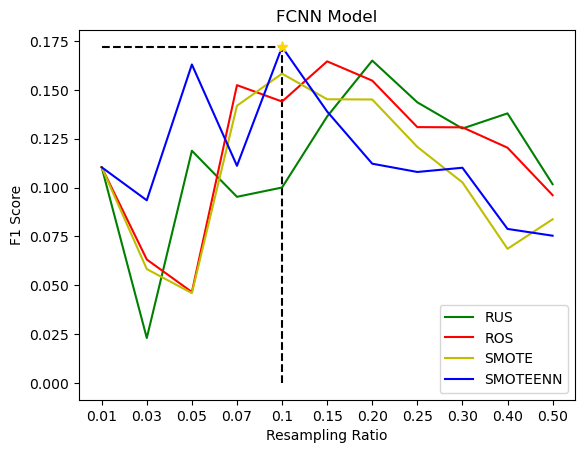

In [68]:
df_FCNN = pd.read_pickle('FCNN_Gridsearch_df.pkl')

# Define data values
x = ['0.01', '0.03', '0.05', '0.07', '0.1', '0.15', '0.20', '0.25', '0.30', '0.40', '0.50']
y = df_FCNN['f1score_under_val'].values
z = df_FCNN['f1score_over_val'].values
a = df_FCNN['f1score_smote_val'].values
b = df_FCNN['f1score_smoteenn_val'].values

# Plot a simple line chart
plt.plot(x, y, 'g', label='RUS')
plt.plot(x, z, 'r', label='ROS')
plt.plot(x, a, 'y', label='SMOTE')
plt.plot(x, b, 'b', label='SMOTEENN')

plt.plot('0.1', max(df_FCNN['f1score_smoteenn_val'].values), marker = '*', ms = 8, mec = 'gold', mfc = 'gold')
plt.hlines(max(df_FCNN['f1score_smoteenn_val'].values), 0, '0.1', color='black', linestyles= 'dashed')  # Stems
plt.vlines('0.1', 0, max(df_FCNN['f1score_smoteenn_val'].values), color='black', linestyles= 'dashed')  # Stems
plt.xlabel("Resampling Ratio")
plt.ylabel("F1 Score")
plt.title("FCNN Model")
plt.legend()
plt.show()

In [75]:
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_base = NeuralNetClassifier(FCNN2,
                                                  max_epochs=20,
                                                  lr=0.1,
                                                  batch_size = 64,
                                                  train_split = predefined_split(valid_ds),
                                                  iterator_train__shuffle=True,
                                                  criterion = nn.NLLLoss(),
                                                  verbose = 0,
                                                  device='cuda',  # uncomment this to train with CUDA
                                                  )
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_tuned = NeuralNetClassifier(FCNN2,
                                                  max_epochs=20,
                                                  lr=0.05,
                                                  batch_size = 64,
                                                  train_split = predefined_split(valid_ds),
                                                  iterator_train__shuffle=True,
                                                  verbose = 0,
                                                  criterion = nn.NLLLoss(weight = torch.Tensor([0.01, 0.99])),
                                                  device='cuda',  # uncomment this to train with CUDA
                                                  )
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_resampled_tuned = NeuralNetClassifier(FCNN2,
                                                  max_epochs=20,
                                                  lr=0.05,
                                                  batch_size = 64,
                                                  train_split = predefined_split(valid_ds),
                                                  iterator_train__shuffle=True,
                                                  verbose = 0,
                                                  criterion = nn.NLLLoss(),
                                                  device='cuda',  # uncomment this to train with CUDA
                                                  )

resample = SMOTEENN(sampling_strategy = 0.1, random_state=102022)
X_resampled, y_resampled = resample.fit_resample(X_train, y_train)



X_resampled_torch = torch.tensor(X_resampled.values, dtype = torch.float32)
y_resampled_torch = torch.tensor(y_resampled.values, dtype = torch.int64).reshape(-1)

X_train_torch = torch.tensor(X_train.values, dtype = torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype = torch.int64).reshape(-1)

X_val_torch = torch.tensor(X_val.values, dtype = torch.float32)
y_val_torch = torch.tensor(y_val.values, dtype = torch.int64).reshape(-1)

X_test_torch = torch.tensor(X_test.values, dtype = torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype = torch.int64).reshape(-1)

valid_ds = Dataset(X_val_torch, y_val_torch)

torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_base.fit(X_train_torch, y_train_torch)
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_tuned.fit(X_train_torch, y_train_torch)
torch.manual_seed(102022)
torch.cuda.manual_seed(102022)
classifier_resampled_tuned.fit(X_resampled_torch, y_resampled_torch)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=FCNN2(
    (dense1): Linear(in_features=33, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do1): Dropout(p=0.25, inplace=False)
    (dense2): Linear(in_features=128, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do2): Dropout(p=0.25, inplace=False)
    (dense3): Linear(in_features=64, out_features=32, bias=True)
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (do3): Dropout(p=0.25, inplace=False)
    (dense4): Linear(in_features=32, out_features=2, bias=True)
  ),
)

In [76]:
y_train_predict_base = classifier_base.predict(X_train_torch)
y_val_predict_base = classifier_base.predict(X_val_torch)
y_test_predict_base = classifier_base.predict(X_test_torch)
y_train_predict_proba_base = classifier_base.predict_proba(X_train_torch)
y_val_predict_proba_base = classifier_base.predict_proba(X_val_torch)
y_test_predict_proba_base = classifier_base.predict_proba(X_test_torch)

y_train_predict_tuned = classifier_tuned.predict(X_train_torch)
y_val_predict_tuned = classifier_tuned.predict(X_val_torch)
y_test_predict_tuned = classifier_tuned.predict(X_test_torch)
y_train_predict_proba_tuned = classifier_tuned.predict_proba(X_train_torch)
y_val_predict_proba_tuned = classifier_tuned.predict_proba(X_val_torch)
y_test_predict_proba_tuned = classifier_tuned.predict_proba(X_test_torch)

y_train_predict_resampled_tuned = classifier_resampled_tuned.predict(X_train_torch)
y_val_predict_resampled_tuned = classifier_resampled_tuned.predict(X_val_torch)
y_test_predict_resampled_tuned = classifier_resampled_tuned.predict(X_test_torch)
y_train_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_train_torch)
y_val_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_val_torch)
y_test_predict_proba_resampled_tuned = classifier_resampled_tuned.predict_proba(X_test_torch)

In [77]:
accuracy = accuracy_score(y_val_torch,y_val_predict_base)
precision = precision_score(y_val_torch,y_val_predict_base)
recall = recall_score(y_val_torch,y_val_predict_base)
f1 = f1_score(y_val_torch,y_val_predict_base)
roc_auc = roc_auc_score(y_val_torch,y_val_predict_proba_base[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_base[:,1])
print('Base Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val_torch,y_val_predict_tuned)
precision = precision_score(y_val_torch,y_val_predict_tuned)
recall = recall_score(y_val_torch,y_val_predict_tuned)
f1 = f1_score(y_val_torch,y_val_predict_tuned)
roc_auc = roc_auc_score(y_val_torch,y_val_predict_proba_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_tuned[:,1])
print('Tuned Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

accuracy = accuracy_score(y_val_torch,y_val_predict_resampled_tuned)
precision = precision_score(y_val_torch,y_val_predict_resampled_tuned)
recall = recall_score(y_val_torch,y_val_predict_resampled_tuned)
f1 = f1_score(y_val_torch,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val_torch,y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Base Model: 	accuracy: 0.9897 	precision: 0.25 	recall: 0.0133 	f1: 0.0253 	roc_auc: 0.8419 	lift: 16.0
Tuned Model: 	accuracy: 0.9093 	precision: 0.0622 	recall: 0.5733 	f1: 0.1123 	roc_auc: 0.8303 	lift: 17.3
R&T Model: 	accuracy: 0.9705 	precision: 0.1158 	recall: 0.2933 	f1: 0.166 	roc_auc: 0.8076 	lift: 20.0


In [78]:
print('----------------------------------------------------------------------------------')
cm_base = confusion_matrix(y_val,y_val_predict_base) #Create a confusion matrix of GT labels and predictions
print('CM Base')
print(cm_base)
cm_tuned = confusion_matrix(y_val,y_val_predict_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Tuned')
print(cm_tuned)
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Base
[[7422    3]
 [  74    1]]
----------------------------------------------------------------------------------
CM Tuned
[[6777  648]
 [  32   43]]
----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7257  168]
 [  53   22]]
----------------------------------------------------------------------------------


Plot PR curves of Resampled & Tuned Model:


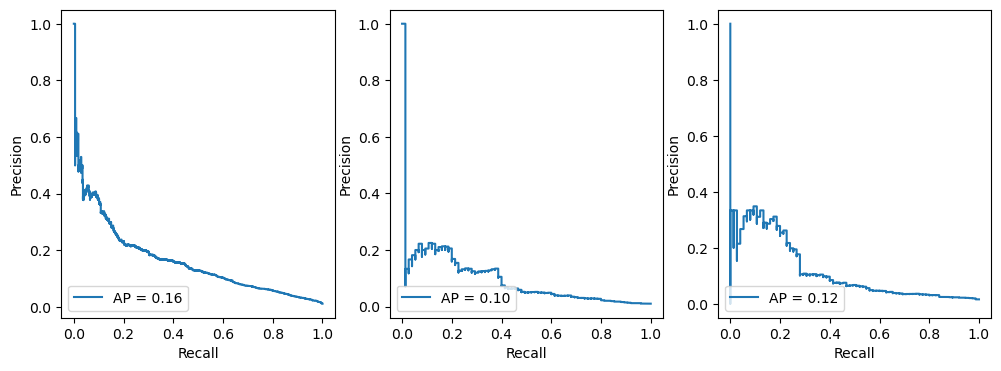

PR_AUC Train: 0.1636 	| PR_AUC Val: 0.0981 	| PR_AUC Test: 0.1159


In [79]:
print('Plot PR curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba_resampled_tuned[:,1])
AP_train = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
PR_curve_train.plot(ax1)
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba_resampled_tuned[:,1])
AP_val = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
PR_curve_val.plot(ax2)
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba_resampled_tuned[:,1])
AP_test = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
PR_curve_test.plot(ax3)
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))

In [80]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned[:,1])
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned[:,1])
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned[:,1])
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned[:,1])
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned[:,1])
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.9729 	precision: 0.1598 	recall: 0.4017 	f1: 0.2287 	roc_auc: 0.9134 	pr_auc: 0.1636 	lift_score: 22.0
R&T Model Val: 		accuracy: 0.9705 	precision: 0.1158 	recall: 0.2933 	f1: 0.166 	roc_auc: 0.8076 	pr_auc: 0.0981 	lift_score: 20.0
R&T Model Test: 	accuracy: 0.9705 	precision: 0.1117 	recall: 0.28 	f1: 0.1597 	roc_auc: 0.8624 	pr_auc: 0.1159 	lift_score: 22.7
